# Improved KNN for forecasting

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.utils import check_array
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.validation import check_is_fitted
from aeon.visualisation import plot_series
from aeon.distances import minkowski_distance
from warnings import simplefilter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Improved KNN

In [2]:
class ImprovedKNeighborsRegressor(KNeighborsRegressor):
    def __init__(
        self,
        n_neighbors = 5,
        aggregator = 'median',
        algorithm = 'brute',
        metric = minkowski_distance
    ):
        super().__init__(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            metric = metric
        )
        self.aggregator = aggregator

    def predict(self, X):
        neigh_dist, neigh_ind = self.kneighbors(X)
        _y = self._y
        _X = self._fit_X

        if _y.ndim == 1:
            _y = _y.reshape((-1, 1))

        if self.aggregator == 'mean':
            y_pred = np.mean(_y[neigh_ind], axis=1)
        elif self.aggregator == 'median':
            y_pred = np.median(_y[neigh_ind], axis=1)
        else:
            regressor = MultiOutputRegressor(self.aggregator).fit(
                _X[neigh_ind][0], 
                _y[neigh_ind][0]
            )
            y_pred = regressor.predict(X)
        if self._y.ndim == 1:
            y_pred = y_pred.ravel()

        return y_pred

In [3]:
knn = ImprovedKNeighborsRegressor(n_neighbors=3, aggregator=SVR())

## Forecasting
Importando aeon

In [4]:
from aeon.datasets import load_airline
from aeon.forecasting.model_selection import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

y = load_airline()

### Definindo funções auxiliares

In [5]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        # print(i, train, test)
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

In [6]:
from matplotlib.ticker import MaxNLocator
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels)

Definindo horizonte de forecasting e tamanho da janela

In [7]:
forecast_window_size = 12
window_length = 20
fh = np.arange(1, forecast_window_size+1)
y_train, y_test = temporal_train_test_split(y, fh=fh)

Instanciando o ImprovedKNeighborsRegressor

In [8]:
from sklearn.linear_model import LinearRegression
from aeon.forecasting.compose import make_reduction
from aeon.distances import dtw_distance


In [9]:
knn = ImprovedKNeighborsRegressor(n_neighbors=5, aggregator=SVR(kernel='linear', C=1), metric=dtw_distance)

Instanciando o forecaster através da função make_reduction, que transforma um regressor do Sklearn em Forecaster

In [10]:
forecaster = make_reduction(
    knn, window_length=window_length,
    strategy="multioutput", windows_identical=True
)

Fittando e predizendo para o horizonte fh

In [11]:
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()

Visualização de resultados

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

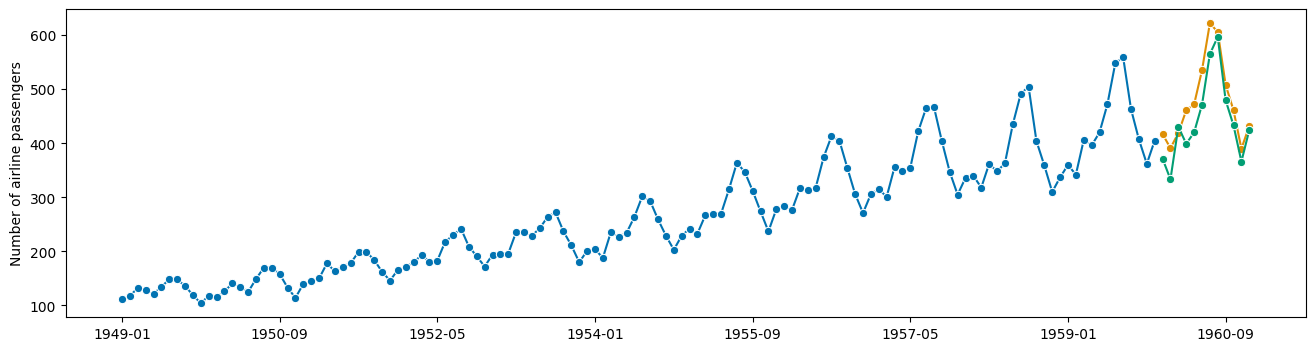

In [12]:
from aeon.visualisation import plot_series
plot_series(y_train, y_test, y_pred)

## Creating a Class for ImprovedKNNForecaster

In [13]:
from aeon.forecasting.base import BaseForecaster

In [14]:
class ImprovedKNeighborsForecaster(BaseForecaster):
    def __init__(
        self, 
        window_length,
        n_neighbors,
        aggregator,
        metric,
        strategy
    ):
        kneighbors = ImprovedKNeighborsRegressor(
            n_neighbors=n_neighbors, 
            aggregator=aggregator, 
            metric=metric
        )

        self.forecaster = make_reduction(
            kneighbors, window_length=window_length,
            strategy=strategy, windows_identical=True
        )
                
    
    def fit(self, y, fh):
        self.forecaster.fit(y_train, fh=fh)

    def predict(self):
        return self.forecaster.predict()


In [15]:
forecaster = ImprovedKNeighborsForecaster(20, 5, SVR(kernel='linear'), dtw_distance, 'multioutput')
forecaster.fit(y_train, fh)
y_pred = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

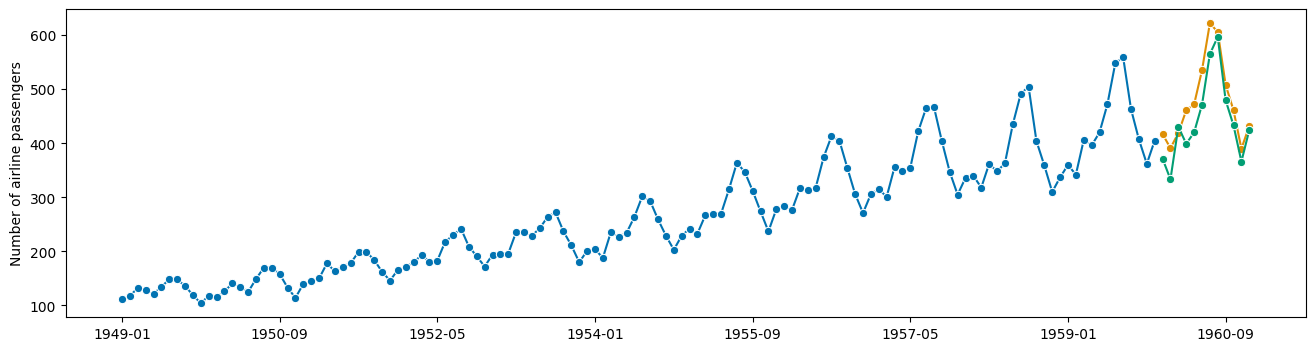

In [16]:
plot_series(y_train, y_test, y_pred)